In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FerModel(nn.Module):
    def __init__(self, num_classes=7):
        super(FerModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv3 = nn.Conv2d(512, 384, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(384)

        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(384, 192, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(192)

        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)

        self.conv5 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(384)

        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.4)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3456, 256)
        self.batch_norm5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = nn.functional.relu(self.conv3(x))
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = nn.functional.relu(self.conv4(x))
        x = self.batch_norm3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = nn.functional.relu(self.conv5(x))
        x = self.batch_norm4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.batch_norm5(x)
        x = self.dropout5(x)

        x = self.fc2(x)

        return nn.functional.softmax(x, dim=1)
dataset_path = "/kaggle/input/presentation/train/train"
test_dataset_path = "/kaggle/input/presentation/test (1)/test"
batch_size = 128
lr = 1e-3
epochs = 250
num_classes = 7
transform_train = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
transform_test = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])
full_dataset = ImageFolder(root=dataset_path, transform=transform_train)
    # Split the dataset into training and validation sets

train_loader = DataLoader(dataset=full_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ImageFolder(root=test_dataset_path, transform=transform_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

model = FerModel(num_classes=num_classes).to(device)
    # Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print metrics after each epoch
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

Epoch 1/250, Training Loss: 1.8513, Training Accuracy: 0.2941, Testing Loss: 1.8130, Testing Accuracy: 0.3387
Epoch 2/250, Training Loss: 1.7509, Training Accuracy: 0.4027, Testing Loss: 1.7028, Testing Accuracy: 0.4518
Epoch 3/250, Training Loss: 1.6979, Training Accuracy: 0.4594, Testing Loss: 1.6694, Testing Accuracy: 0.4794
Epoch 4/250, Training Loss: 1.6637, Training Accuracy: 0.4939, Testing Loss: 1.6529, Testing Accuracy: 0.5038
Epoch 5/250, Training Loss: 1.6476, Training Accuracy: 0.5107, Testing Loss: 1.6252, Testing Accuracy: 0.5332
Epoch 6/250, Training Loss: 1.6337, Training Accuracy: 0.5242, Testing Loss: 1.6163, Testing Accuracy: 0.5444
Epoch 7/250, Training Loss: 1.6210, Training Accuracy: 0.5374, Testing Loss: 1.6129, Testing Accuracy: 0.5429
Epoch 8/250, Training Loss: 1.6174, Training Accuracy: 0.5401, Testing Loss: 1.6077, Testing Accuracy: 0.5568
Epoch 9/250, Training Loss: 1.6080, Training Accuracy: 0.5520, Testing Loss: 1.5867, Testing Accuracy: 0.5695
Epoch 10/2

KeyboardInterrupt: 

We stopped the code at 150 epochs because the accuracy got stagnant at 66%.It is not because of code error.

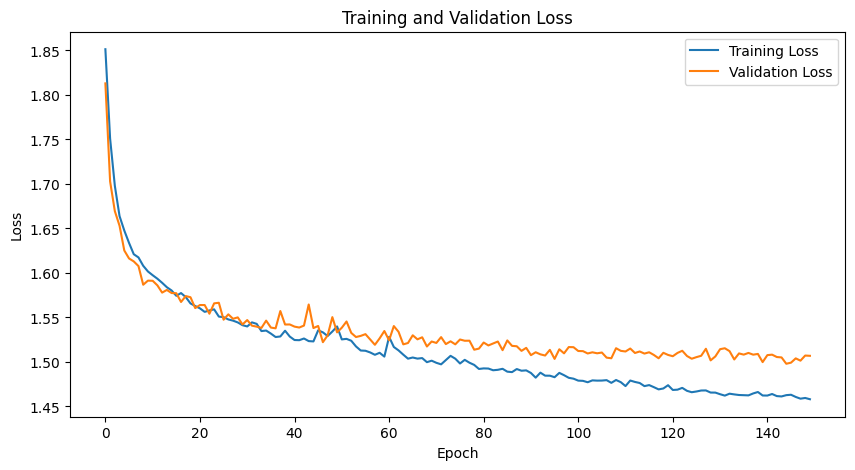

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


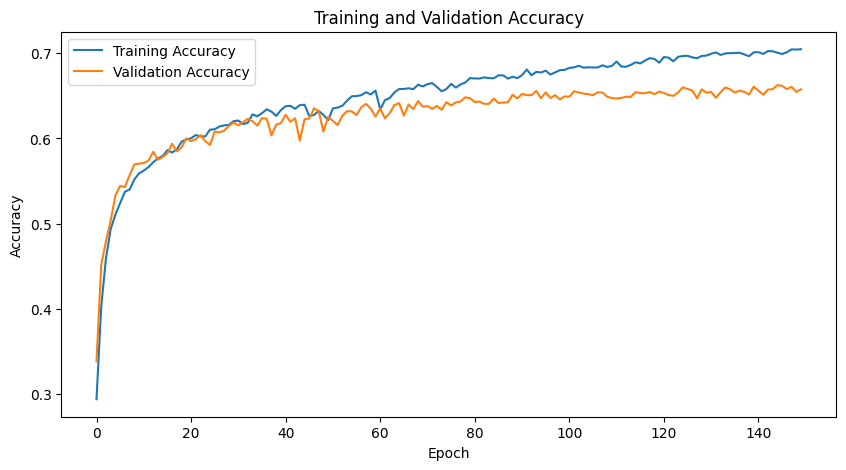

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Correctly Predicted Images:


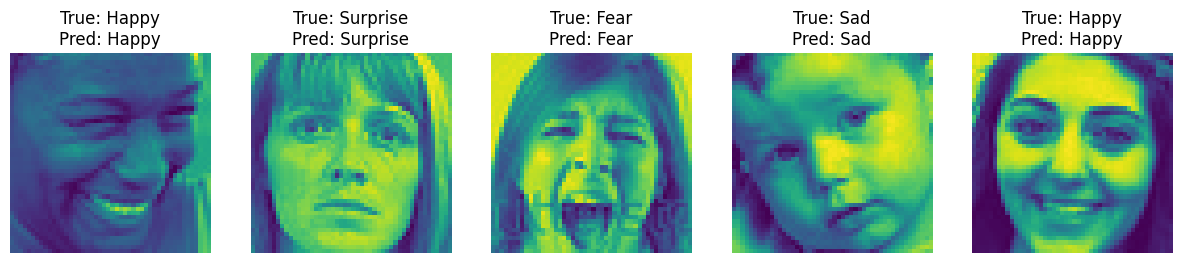

Incorrectly Predicted Images:


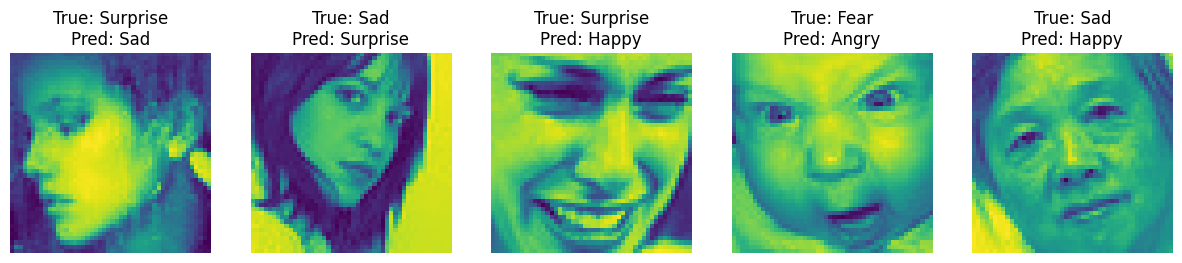

In [ ]:
model.eval()
correct = 0
total = 0
correct_images_info = []
incorrect_images_info = []
class_names = {0: 'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'}
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct_mask = predicted.eq(labels)
        incorrect_mask = ~correct_mask

        correct_images = inputs[correct_mask]
        correct_labels = labels[correct_mask]
        correct_predictions = predicted[correct_mask]

        incorrect_images = inputs[incorrect_mask]
        incorrect_labels = labels[incorrect_mask]
        incorrect_predictions = predicted[incorrect_mask]

        # Store information about correctly predicted images
        for i in range(len(correct_images)):
            correct_images_info.append({
                'image': correct_images[i].cpu().numpy(),
                'true_label': correct_labels[i].item(),
                'predicted_label': correct_predictions[i].item()
            })

        # Store information about incorrectly predicted images
        for i in range(len(incorrect_images)):
            incorrect_images_info.append({
                'image': incorrect_images[i].cpu().numpy(),
                'true_label': incorrect_labels[i].item(),
                'predicted_label': incorrect_predictions[i].item()
            })

        break  # Only process the first batch

# Print some correctly predicted images
print("Correctly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(correct_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(correct_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[correct_images_info[i]["true_label"]]
    pred_label = class_names[correct_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

# Print some incorrectly predicted images
print("Incorrectly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(incorrect_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(incorrect_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[incorrect_images_info[i]["true_label"]]
    pred_label = class_names[incorrect_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


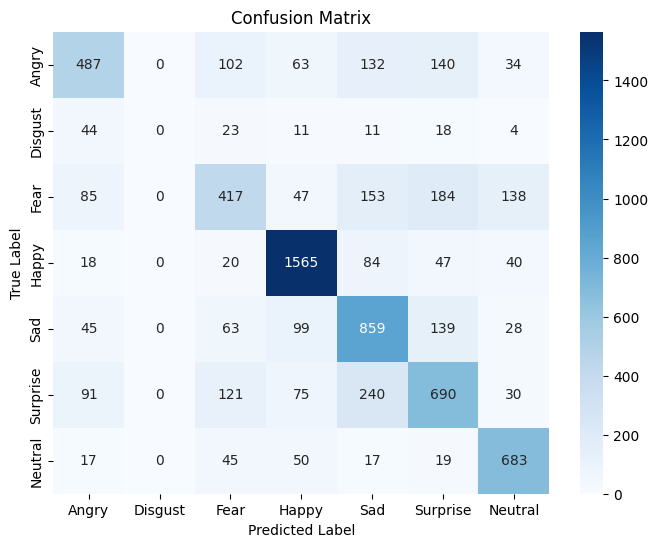

In [ ]:
from sklearn.metrics import confusion_matrix
model.eval()
with torch.no_grad():
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_labels = []
        all_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted_valid = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted_valid.eq(labels).sum().item()

            # Store labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_valid.cpu().numpy())
import seaborn as sn
import pandas as pd
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())
plt.figure(figsize=(8, 6))
sn.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')